# Load libraries, define constants, functions, and classes

* libraries

in order to get tensorrt_libs to install and not give an error w.r.t version-ing

https://github.com/NVIDIA/TensorRT/issues/2933

In [1]:
import os

import sys
sys.path.append("../2_train_and_test_models")

# (1) https://github.com/shap/shap/issues/1551
# (2) https://github.com/shap/shap/issues/1456
# (3) https://stackoverflow.com/questions/47940040/how-to-set-input-shape-of-a-trained-model-in-keras
import tensorflow
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Reshape
tensorflow.random.set_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from params import ROOT, GENOMES, Params

# from MORALE.test import MORALE
# from GRL.test import GRL
# from BM.test import basic_model

from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.fasta import PyfaidxCoordsToVals
from collections import defaultdict
from math import ceil
from sklearn.metrics import mean_absolute_error
from scipy.stats import wilcoxon
from collections import defaultdict

# # From https://github.com/kundajelab/deeplift
# import shap
# from deeplift.visualization import viz_sequence
# from deeplift.dinuc_shuffle import dinuc_shuffle

# Why did we add these? 
#
# >> https://github.com/shap/shap/issues/1551 <<
#
# SHAP & DeepExplainer are super finicky with TF2. We downgrade
# to a working version of TF2 (2.15.0) so that we can disable
# TF2 behavior and import the session.
# from tensorflow.compat.v1.keras.backend import get_session
# tensorflow.compat.v1.disable_v2_behavior()

np.random.seed(42)
tensorflow.random.set_seed(42)

2025-03-07 01:53:04.924586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 01:53:04.948846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741330384.975296 3396700 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741330384.982968 3396700 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 01:53:05.007999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

* constants

In [2]:
SEQ_LEN     = 500
NUM_SEQS    = 5
SAVE        = False
SPECIES     = ["mm10", "hg38"]

TFS         = ["CTCF"]
# "CTCF", "CEBPA", "HNF4A", "RXRA"

SPECIES1    = "mm10"
SPECIES2    = "hg38"

# Shorthand names for all model types to include in plots
MODELS = [
    "BM",
    "GRL",
    "MORALE"
]

# Plot-acceptable names for model types
MODEL_NAMES = {
    "BM-mm10": "Mouse-trained",
    "BM-hg38": "Human-trained",
    "GRL-mm10": "Mouse-trained\n(+GRL)",
    "GRL-hg38": "Human-trained\n(+GRL)",
    "MORALE-mm10": "Mouse-trained\n(+MORALE)",
    "MORALE-hg38": "Human-trained\n(+MORALE)"
}

ATTR_SITES  = ["dTP", "dTN"] # for tfmodisco

* classes

In [3]:
class TestGenerator(Sequence):
    """
    This generator retrieves all coordinates for windows in the test set
    and converts the sequences in those windows to one-hot encodings.
    Which species to retrieve test windows for is specified with
    the "test_species" argument.
    """
    def __init__(self, indices, test_species, skip=None):
        self.test_species   = test_species
        self.testfile       = self.get_test_bed_file(TFS[0], test_species) # doesn't matter which TF we use, we don't process the labels
        self.converter      = PyfaidxCoordsToVals(GENOMES[test_species])
        self.skip           = skip

        # Load all coordinates for the test data into memory
        self.load_coords(list(indices))

        self.steps      = len(self.coords)

    def __len__(self):
        return self.steps

    def __getitem__(self, batch_index):
        # convert a batch's worth of coordinates into one-hot sequences
        # here a batch has size 1 because we'll expand each sequence into
        # a lot of ablated sequences later

        batch           = self.converter(self.coords[batch_index : min(len(self.coords), batch_index + 1)])
        domain_labels   = np.ones(batch.shape[0],)
 
        return batch
        #return {"sequence":batch, "index":domain_labels}

    def load_coords(self, indices):
        # load all coordinates for the test data into memory

        # this is WAY faster that the naive way of doing this
        df = pd.read_csv(self.testfile, sep='\t', header=None)

        # filter for only the lines corresponding to the indices we care about
        df = df.iloc[indices]
        self.coords = [Coordinates(row[0], row[1], row[2]) for row in zip(df[0], df[1], df[2])]
        
        # after we've subsetted, if you want to speed things up,
        # you get just retain every nth site
        if self.skip is not None:
            self.coords = self.coords[::self.skip]

        # finally, we shuffle the coordinates
        random.shuffle(self.coords)

        # we add on to this by just converting all the coordinates to one-hot sequences
        #self.ohes = self.converter(self.coords)

    def get_coords(self):
        return self.coords

    def get_test_bed_file(self, tf, test_species):
        return(f"{ROOT}/data/{test_species}/{tf}/chr2.bed")

* Helper functions to use

In [4]:
def get_preds_file(model, tf, source_species, domain):
    preds_root = f"{ROOT}/output"
    os.makedirs(preds_root, exist_ok=True)
    return f"{preds_root}/{model}_tf-{tf}_trained-{source_species}_tested-{domain}.preds.npy"

def get_labels_file(model, tf, source_species, domain):
    preds_root = f"{ROOT}/output"
    os.makedirs(preds_root, exist_ok=True)
    return f"{preds_root}/{model}_tf-{tf}_trained-{source_species}_tested-{domain}.labels.npy"

def load_fivefold_data(average=False, verbose=False):
    preds_dict      = defaultdict(lambda : defaultdict(lambda : dict()))
    labels_dict     = defaultdict(lambda : defaultdict(lambda : dict()))
    bound_indices   = defaultdict(lambda : defaultdict(lambda : dict()))
    unbound_indices = defaultdict(lambda : defaultdict(lambda : dict()))

    # Loop over mouse-trained, human-trained models, and domain-adaptive models
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    if verbose:
                        print(f"\t({model} on {tf} when: {source}-trained, and {target}-tested)")
                    preds_file  = get_preds_file(model=model, tf=tf, source_species=source, domain=target)
                    labels_file = get_labels_file(model=model, tf=tf, source_species=source, domain=target)
                
                    try:
                        # Load them
                        preds = np.load(preds_file)
                        labels = np.load(labels_file)

                        # Calculate if we need to truncate the labels
                        if preds.shape[0] != labels.shape[0]:
                            print("\nTruncating labels\n")
                            labels = labels[:preds.shape[0]]

                        assert preds.shape[0] == labels.shape[0]

                        if average:
                            # We take the average of the sigmoid values across the five-folds
                            # to determine the confusion matrix
                            preds_dict[f"{model}-{source}"][tf][target] = np.mean(preds, axis=1)
                        else:                        
                            # We save predictions from each of the five-folds per model, TF, source, and target
                            preds_dict[f"{model}-{source}"][tf][target] = np.load(preds_file)
                        
                        labels_dict[f"{model}-{source}"][tf][target] = np.load(labels_file)

                        # Store unbound and bound indices for all models, TFs, sources, and targets
                        bound_indices[f"{model}-{source}"][tf][target]      = np.nonzero(labels == 1)[0]
                        unbound_indices[f"{model}-{source}"][tf][target]    = np.nonzero(labels == 0)[0]
                        
                    except:
                        print("Could not load regular preds/labels files")

    return preds_dict, labels_dict, bound_indices, unbound_indices

def generate_confusion_matrix(verbose=False, bound_threshold=0.98, unbound_threshold=0.01):
    """
    Since we are generating attribtuions from bound sites for each TF, we characterize this 
    confusion matrix as one that 'finds' the most extreme sites (i.e. for those that are bound,
    sites that all folds agree as bound (>0.8 is our default)).
    """

    # (1) Load the predictions, labels, and bound/unbound indices
    print("\n=== Loading the predictions, labels, and bound/unbound indices ===\n")
    preds_dict, labels_dict, bound_indices, unbound_indices = load_fivefold_data(average=True, verbose=verbose) # we take the average of the five folds

    # Indices we need to populate
    ex_tp_indices   = defaultdict(lambda: defaultdict(lambda: {}))
    ex_fp_indices   = defaultdict(lambda: defaultdict(lambda: {}))
    ex_tn_indices   = defaultdict(lambda: defaultdict(lambda: {}))
    ex_fn_indices   = defaultdict(lambda: defaultdict(lambda: {}))

    # (2) Generate the confusion matrix
    print("\n=== Generating TPs, FPs, TNS, and FNs by looking at bound/unbound sites (in comparison to the predictions) ===\n")
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    
                    model_name= f"{model}-{source}"

                    if verbose:
                        print(f"\t({model} for tf-{tf}, source-{source}, target-{target})")

                    # We use <= 0.5 to classify as unbound 
                    bound_predictions_indices       = np.nonzero(preds_dict[model_name][tf][target] > bound_threshold)[0]
                    unbound_predictions_indices     = np.nonzero(preds_dict[model_name][tf][target] <= unbound_threshold)[0]

                    # We store these for each example, but they will be constant across target-tfs pairs
                    ground_truth_bound_indices      = bound_indices[model_name][tf][target]
                    ground_truth_unbound_indices    = unbound_indices[model_name][tf][target]

                    # For each example the models predicted as bound...
                    ex_tp_indices[model_name][tf][target] = set(bound_predictions_indices).intersection(set(ground_truth_bound_indices))
                    ex_fp_indices[model_name][tf][target] = set(bound_predictions_indices).intersection(set(ground_truth_unbound_indices))

                    # For each example the models predicted as bound...
                    ex_tn_indices[model_name][tf][target] = set(unbound_predictions_indices).intersection(set(ground_truth_unbound_indices))
                    ex_fn_indices[model_name][tf][target] = set(unbound_predictions_indices).intersection(set(ground_truth_bound_indices))

    return ex_tp_indices, ex_fp_indices, ex_tn_indices, ex_fn_indices

def get_agreement_sites(species_1, species_2, verbose=False):
    """ 
    On top of capturing the most 'extreme' sites (i.e., those who
    raw sigmoid value is high for the average over the five-folds),
    we also want those that the source and the target model both 
    are found to agree on.
    """

    assert species_1 != species_2, "Species 1 and Species 2 must be different"
    assert species_1 in SPECIES, f"Species 1 must be one of {SPECIES}"
    assert species_2 in SPECIES, f"Species 2 must be one of {SPECIES}"

    ex_tp_indices, ex_fp_indices, ex_tn_indices, ex_fn_indices = generate_confusion_matrix(verbose=verbose)
        
    extreme_agreement_sites = defaultdict(lambda : dict())

    for tf in TFS:
        
        # If the site classification agrees for both the 'lower' and 'upper' bound, our domain adaptive models should get it right
        extreme_agreement_sites[tf]["TP"] = ex_tp_indices[f"BM-{species_1}"][tf][species_2].intersection(ex_tp_indices[f"BM-{species_2}"][tf][species_2])
        extreme_agreement_sites[tf]["FP"] = ex_fp_indices[f"BM-{species_1}"][tf][species_2].intersection(ex_fp_indices[f"BM-{species_2}"][tf][species_2])
        extreme_agreement_sites[tf]["TN"] = ex_tn_indices[f"BM-{species_1}"][tf][species_2].intersection(ex_tn_indices[f"BM-{species_2}"][tf][species_2])
        extreme_agreement_sites[tf]["FN"] = ex_fn_indices[f"BM-{species_1}"][tf][species_2].intersection(ex_fn_indices[f"BM-{species_2}"][tf][species_2])

    return extreme_agreement_sites

In [5]:
'''
From Keras:

Weights are loaded based on the network's topology. This means the architecture should be the same as when the weights were saved.
Note that layers that don't have weights are not taken into account in the topological ordering, so adding or removing layers is 
fine as long as they don't have weights.

We redefine our models so that we can use it with tf 2.18.0; for example
we remove the MomentAlignmentLayer and just use the in our model. There are
no weights to load, so we don't need to worry about that.
'''
def basic_model(params):
	# Inputs
	seq_input	= Input(shape = (params.seqlen, 4, ))
	# index		= Input(shape = (1,), name = 'index') # we don't use this here

	# Basic, CNN model
	seq = Conv1D(params.convfilters, params.filtersize, padding = "same")(seq_input)
	seq = Activation("relu")(seq)
	seq = MaxPooling1D(padding = "same", strides = params.strides, pool_size = params.pool_size)(seq)
	seq = LSTM(params.lstmnodes)(seq)
	seq = Dense(params.dl1nodes, activation = "relu")(seq)
	seq = Dropout(params.dropout)(seq)
	seq = Dense(params.dl2nodes, activation = "sigmoid")(seq)
	seq = Dense(1)(seq)

	# Label
	result = Activation("sigmoid")(seq)

	return Model(inputs = seq_input, outputs = result, name = "BM")

def GRL(params, lambda_=1.0):
	# Here we specify the architecture of the domain-adaptive model.

	# Inputs
	seq_input	= Input(shape = (params.seqlen, 4, ))
	# index		= Input(shape = (1,), name = 'index')

	# Shared convolutional layer
	seq = Conv1D(params.convfilters, params.filtersize, padding="same")(seq_input)
	seq = Activation('relu')(seq)
	seq = MaxPooling1D(padding = "same", strides = params.strides, pool_size = params.pool_size)(seq)

	# Classifier technically includes the LSTM layer (from Cochran et al.)
	classifier		= LSTM(params.lstmnodes)(seq)
	classifier		= Dense(params.dl1nodes)(classifier)
	classifier		= Activation('relu')(classifier)
	classifier		= Dense(params.dl2nodes, activation = 'sigmoid')(classifier)
	class_result	= Dense(1, activation = 'sigmoid', name = "classifier")(classifier)

	# Discriminator acts upon 
	discriminator	= Reshape((params.get_reshape_size(), ))(seq)
	#discriminator	= GradientReversal(lambda_)(discriminator)
	discriminator	= Dense(params.dl1nodes)(discriminator)
	discriminator	= Activation('relu')(discriminator)
	discriminator	= Dense(params.dl2nodes, activation = 'sigmoid')(discriminator)
	disc_result		= Dense(1, activation = 'sigmoid', name = "discriminator")(discriminator)

	model = Model(inputs = seq_input, outputs = [class_result, disc_result], name = "GRL")
	return model

def MORALE(params):
    # Inputs
    seq_input	= Input(shape = (params.seqlen, 4,))
    # index		= Input(shape = (), name='index')

    # To the embedding of the sequence
    seq         = Conv1D(params.convfilters, params.filtersize, padding = "same")(seq_input)
    seq         = Activation("relu")(seq)
    seq         = MaxPooling1D(padding = "same", strides = params.strides, pool_size = params.pool_size)(seq)
    embedding   = LSTM(params.lstmnodes)(seq)

    # Continue with the model, specifying the architecture for binding label prediction
    seq		= Dense(params.dl1nodes, activation = "relu")(embedding)
    seq		= Dropout(params.dropout)(seq)
    seq		= Dense(params.dl2nodes, activation = "sigmoid")(seq)
    seq		= Dense(1)(seq)
    result	= Activation("sigmoid")(seq)

    model = Model(inputs = seq_input, outputs = result, name = "MORALE")
    #model = Model(inputs = [seq_input, index], outputs = result, name = "MORALE")
    
    return model

In [6]:
def get_model_file(model, tf, source_species, run):
    # This function returns the filepath where the model for a given
    # TF, training species, and run is saved.
    # By default, the file for the best model across all training epochs
    # is returned, you can change model_type to select the last model instead.
    # This function specifically looks for the most recent model file,
    # if there are multiple for the same run-TF-species combo.

    assert model in MODELS, f"Model must be one of {MODELS}"

    try:
        run_int = int(run)
    except:
        print("Error: You need to pass in a run number that can be cast to int.")

    model_file_prefix = f"{ROOT}/models/{tf}/{source_species}_trained/{model}"
    model_file_suffix = f"_run{str(run)}.weights.h5"
    
    # Get all files that match the prefix and suffix
    files = [f for f in os.listdir(model_file_prefix) if f.endswith(model_file_suffix)]
    
    # sort files and return the one that is most recent
    latest_file = max([f"{model_file_prefix}/{f}" for f in files], key=os.path.getctime)
    return latest_file

def load_keras_model(model, tf, source_species, run, model_file):

    assert model in MODELS, f"Model must be one of {MODELS}"

    params  = Params(["Attribution", tf, source_species, run], verbose=False)

    # Load based on model type
    if model == "BM":
        model = basic_model(params)
    elif model == "MORALE":
        model = MORALE(params)
    elif model == "GRL":    
        model = GRL(params)

    model.load_weights(model_file, skip_mismatch=False)

    return model

def get_models_all_runs(runs=5):
    saved_models = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [])))
    
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    for run in range(runs):
                        model_file = get_model_file(model=model, tf=tf, source_species=source, run=run+1)
                        print("Loading model from:", model_file)
                        saved_models[f"{model}-{source}"][tf][target].append(load_keras_model(model=model, tf=tf, source_species=source, run=run, model_file=model_file))
            
    return saved_models

In [7]:
def build_generators(site_indices, test_species):
    generators = defaultdict(lambda : dict())

    for tf in TFS:
        generators[tf]["TP"]    = TestGenerator(site_indices[tf]["TP"], test_species=test_species, skip=None)

        for site_type, gen in generators[tf].items():
            print(tf, site_type, gen.__len__())
    
    return generators

In [8]:
def dinucleotide_shuffle(seq, num_shuffles=100):
    """Creates a background dataset of dinucleotide-shuffled sequences"""
    seq = np.squeeze(seq)
    shuffled_seqs = dinuc_shuffle(seq, num_shuffles)
    return np.array(shuffled_seqs)

def get_deeplift_deepexplainer_shap_scores(gen_dict, model_name, saved_model, site_type, num_shuffles=100, num_seqs_to_do=None): # background_dataset
    """
    Computes DeepLIFT attributions using SHAP(ley) values!

    Args:
        gen_dict: A dictionary of generators.
        model: The (TensorFlow) model.
        background_dataset: A background dataset (numpy array) to use for DeepLIFT.
        num_seqs_to_do: Optional number of sequences to process.

    Returns:
        A dictionary of attribution scores.
    """
    scores_dict     = dict()
    seqs_dict       = dict()

    # # (0) Create a TFDeep explainer
    # explainer                   = shap.explainers.DeepExplainer(model, background_dataset)

    # (1) Focus generator dict on the specified seq_type
    gen_dict_seq_type = gen_dict[site_type]

    print(f"\n\tFocusing on {site_type} sites from the test set (Chr2).\n")

    shap_values_list= []
    seqs_for_seq_type   = []
    num_seqs = gen_dict_seq_type.__len__()
    if num_seqs_to_do is None:
        num_seqs_to_do = num_seqs
    else:
        num_seqs_to_do = min(num_seqs, num_seqs_to_do)

    print(f"\tGiven the length of the generator, we will process {num_seqs_to_do} sequences.\n")

    # (2) Batch them first, and create background data for each sequence
    for seq_index in range(num_seqs_to_do):
        og_seq = gen_dict_seq_type[seq_index].astype(float)
        seqs_for_seq_type.append(og_seq)

        # og_index = gen_dict_seq_type[seq_index]['index']
        # idxs_for_seq_type.append(og_index)

        # # Create a background dataset for this specific sequence
        # if num_shuffles is None:
        #     background_sequences = dinucleotide_shuffle(og_seq)
        # else:
        #     background_sequences = dinucleotide_shuffle(og_seq, num_shuffles=num_shuffles)

        # Generate a background dataset for this specific sequence
        background_data = dinucleotide_shuffle(og_seq, num_shuffles=num_shuffles)

        # Ensure the shapes are correct, now that background is much larger
        assert background_data.shape == (num_shuffles, og_seq.shape[1], og_seq.shape[2]), f"{background_data.shape} != {(num_shuffles, og_seq.shape[1], og_seq.shape[2])}"

        # Prepare the data for the DeepExplainer with this seq-specific background
        if "GRL" not in model_name:
            explainer = shap.explainers.DeepExplainer(
                (saved_model.input, saved_model.output),
                background_data
            )
        else:
            explainer = shap.explainers.DeepExplainer( # we have the classifier and discriminator outputs
                (saved_model.input, saved_model.output[0]),
                background_data
            )

        # Compute SHAP values (DeepLIFT attributions)
        #shap_values = explainer.shap_values(og_seq).squeeze()
        shap_values = explainer.shap_values(og_seq, check_additivity=False).squeeze()

        if seq_index % 50 == 0:
            print(f"\tUpdate: processed {seq_index} sequences.")

        shap_values_list.append(np.expand_dims(shap_values, axis=0)) # add back the batch dimension

    # Reformat them into batches
    seqs_for_seq_type           = np.concatenate(seqs_for_seq_type, axis=0)
    shap_values_for_seq_type    = np.concatenate(shap_values_list, axis=0)

    # # Prepare the data for the DeepExplainer
    # # Create a TFDeep explainer
    # explainer = shap.explainers.DeepExplainer(saved_model, backgrounds_for_seq_type)

    # # (3) Compute SHAP values (DeepLIFT attributions)
    # shap_values = explainer.shap_values(seqs_for_seq_type).squeeze()

    # seqs_dict[site_type]    = seqs_for_seq_type
    # scores_dict[site_type]  = shap_values_for_seq_type

    return shap_values_for_seq_type, seqs_for_seq_type

def get_deeplift_gradexplainer_shap_scores(gen_dict, model_name, saved_model, site_type, num_shuffles=100, nsamples=200, num_seqs_to_do=None): # background_dataset
    """
    Computes DeepLIFT attributions using SHAP(ley) values!

    Args:
        gen_dict: A dictionary of generators.
        model: The (TensorFlow) model.
        background_dataset: A background dataset (numpy array) to use for DeepLIFT.
        num_seqs_to_do: Optional number of sequences to process.

    Returns:
        A dictionary of attribution scores.
    """

    # (1) Focus generator dict on the specified seq_type
    gen_dict_seq_type = gen_dict[site_type]

    print(f"\n\tFocusing on {site_type} sites from the test set (Chr2).\n")

    shap_values_list    = []
    seqs_for_seq_type   = []
    num_seqs = gen_dict_seq_type.__len__()
    if num_seqs_to_do is None:
        num_seqs_to_do = num_seqs
    else:
        num_seqs_to_do = min(num_seqs, num_seqs_to_do)

    print(f"\tGiven the length of the generator, we will process {num_seqs_to_do} sequences.\n")

    # (2) Batch them first, and create background data for each sequence
    for seq_index in range(num_seqs_to_do):
        og_seq = gen_dict_seq_type[seq_index].astype(float)
        seqs_for_seq_type.append(og_seq)

        # Generate a background dataset for this specific sequence
        background_data = dinucleotide_shuffle(og_seq, num_shuffles=num_shuffles)

        # Prepare the data for the DeepExplainer with this seq-specific background
        if "GRL" not in model_name:
            explainer = shap.explainers.GradientExplainer(
                (saved_model.input, saved_model.output),
                background_data
            )
        else:
            explainer = shap.explainers.GradientExplainer( # we have the classifier and discriminator outputs
                (saved_model.input, saved_model.output[0]),
                background_data
            )

        # Compute SHAP values (DeepLIFT attributions)
        shap_values = explainer.shap_values(og_seq, nsamples=nsamples).squeeze()

        if seq_index % 50 == 0:
            print(f"\tUpdate: processed {seq_index} sequences.")

        shap_values_list.append(np.expand_dims(shap_values, axis=0)) # add back the batch dimension

    # Reformat them into batches
    seqs_for_seq_type           = np.concatenate(seqs_for_seq_type, axis=0)
    shap_values_for_seq_type    = np.concatenate(shap_values_list, axis=0)

    return shap_values_for_seq_type, seqs_for_seq_type

def get_creasted_contributions(intervals, saved_model, genome):
    """
    Computes DeepLIFT attributions using SHAP(ley) values!

    Args:
        gen_dict: A dictionary of generators.
        model: The (TensorFlow) model.
        background_dataset: A background dataset (numpy array) to use for DeepLIFT.
        num_seqs_to_do: Optional number of sequences to process.

    Returns:
        A dictionary of attribution scores.
    """
    import crested
    from crested.tl import contribution_scores

    scores, one_hot_encoded_sequences = contribution_scores(
        input=intervals,
        target_idx=None,
        model=saved_model,
        method='expected_integrated_grad',
        genome=GENOMES[genome],
        transpose=True,
        output_dir=None,
        verbose=True
    )

    return scores, one_hot_encoded_sequences

def read_holdout_bed(tf, species, extreme_agreement_sites):
    
    # Read holdout bed file
    holdout_bed_path = f"{ROOT}/data/{species}/{tf}/chr2.bed"
    holdout_bed = pd.read_csv(holdout_bed_path, sep="\t", names=['chrom', 'start', 'end', 'label'], usecols=['chrom','start','end'])

    # Only keep the extreme agreement sites
    holdout_bed = holdout_bed.iloc[list(extreme_agreement_sites[tf]["TP"])]

    # Create the necessary strings for the regions we need
    chrom_values = holdout_bed.iloc[:, 0]
    start_values = holdout_bed.iloc[:, 1]
    end_values = holdout_bed.iloc[:, 2]

    # Create the region strings
    regions = [
        f"{chrom}:{start}-{end}"
        for chrom, start, end in zip(chrom_values, start_values, end_values)
    ]

    shuffled_indices = np.random.permutation(len(regions))[:2000]
    regions = [regions[i] for i in shuffled_indices]

    return regions

# Generate sites by their classification between the 'lower' (source-on-target) and 'upper' (target-on-target) bound models

In [9]:
# We want to compare the human model, the domain adaptive ones (not here), and the mouse model!
extreme_agreement_sites = get_agreement_sites(species_1=SPECIES1, species_2=SPECIES2, verbose=True)


=== Loading the predictions, labels, and bound/unbound indices ===

	(BM on CTCF when: mm10-trained, and mm10-tested)
	(BM on CTCF when: mm10-trained, and hg38-tested)
	(BM on CTCF when: hg38-trained, and mm10-tested)
	(BM on CTCF when: hg38-trained, and hg38-tested)
	(GRL on CTCF when: mm10-trained, and mm10-tested)
	(GRL on CTCF when: mm10-trained, and hg38-tested)
	(GRL on CTCF when: hg38-trained, and mm10-tested)
	(GRL on CTCF when: hg38-trained, and hg38-tested)
	(MORALE on CTCF when: mm10-trained, and mm10-tested)
	(MORALE on CTCF when: mm10-trained, and hg38-tested)
	(MORALE on CTCF when: hg38-trained, and mm10-tested)
	(MORALE on CTCF when: hg38-trained, and hg38-tested)

=== Generating TPs, FPs, TNS, and FNs by looking at bound/unbound sites (in comparison to the predictions) ===

	(BM for tf-CTCF, source-mm10, target-mm10)
	(BM for tf-CTCF, source-mm10, target-hg38)
	(BM for tf-CTCF, source-hg38, target-mm10)
	(BM for tf-CTCF, source-hg38, target-hg38)
	(GRL for tf-CTCF, sou

## Set up sanity check for motif matching

* We isolate the genomic positions from the test set we are using
and convert them to a seperate fasta file so that we can run motif 
matching with MEME

In [32]:
import os

def filter_bed_file_from_list(bed_file_path, indices_list, output_suffix):
    """
    Filters a BED file based on a list of indices (provided as a Python list).

    Args:
        bed_file_path (str): Path to the input BED file.
        indices_list (list): A Python list of integers representing the (0-based)
                             indices of the lines to keep.
        output_suffix (str): Suffix to add to the output file name.

    Returns:
        None.  Writes the filtered BED file to disk.
    """

    if not isinstance(indices_list, list):
        raise TypeError("indices_list must be a Python list.")
    if not all(isinstance(i, int) for i in indices_list):
        indices_list = list(map(int, indices_list))

    try:
        # Read and filter the BED file
        filtered_lines = []
        with open(bed_file_path, 'r') as infile:
            for i, line in enumerate(infile):
                if i in indices_list:
                    filtered_lines.append(line)
    except FileNotFoundError:
        print(f"Error: BED file not found at {bed_file_path}")
        return

    # Create output file name
    base_name, ext = os.path.splitext(bed_file_path)
    output_file_path = f"{base_name}{output_suffix}{ext}"

    # Write the filtered lines to the output file
    with open(output_file_path, 'w') as outfile:
        outfile.writelines(filtered_lines)

    print(f"Filtered BED file written to: {output_file_path}")


if __name__ == "__main__":

    meme_tf = "CTCF"

    # Define roout for the data
    test_file = f"{ROOT}/data/{SPECIES2}/{meme_tf}/chr2.bed"
    
    # Find sites we want to filter for a chosen TF
    sites_to_match = list(extreme_agreement_sites[meme_tf]['TP'])

    # Filter the BED files for the sites we want to analyze
    filter_bed_file_from_list(
        bed_file_path=test_file,
        indices_list=sites_to_match,
        output_suffix=f"_filtered"
    )

Filtered BED file written to: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/RECOMB/two-species/tensorflow/data/hg38/CTCF/chr2_filtered.bed


In [13]:
%%bash

ROOT="/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/RECOMB/two-species/tensorflow"
TF="CTCF"

SPECIES1="mm10"
SPECIES2="hg38"

bed_file="${ROOT}/data/${SPECIES2}/${TF}/chr2_filtered.bed"
fasta_file="${ROOT}/data/${SPECIES2}/${TF}/chr2_filtered.fasta"

if [ "$SPECIES2" = "hg38" ]; then
    GENOME="${ROOT}/raw_data/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
elif [ "$SPECIES2" = "mm10" ]; then
    GENOME="${ROOT}/raw_data/mm10/mm10_no_alt_analysis_set_ENCODE.fasta"
else
    echo "Error: SPECIES2 is not set to a recognized value (hg38 or mm10)." >&2
    # exit 1  # Optional: Exit with an error code
fi

bedtools getfasta -fi "${GENOME}" -bed "${bed_file}" -fo "${fasta_file}"

# Load all the models we need

In [ ]:
saved_models = get_models_all_runs()

Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-23-44_run1.weights.h5


2025-03-07 01:53:53.846939: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-23-53_run2.weights.h5
Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-24-48_run3.weights.h5
Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-24-59_run4.weights.h5
Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-28-56_run5.weights.h5
Loading mode

# Create ISM-inspired generators

In [ ]:
generators = build_generators(extreme_agreement_sites, test_species=SPECIES2)

CTCF TP 11355


# Generating Attribution Scores

## Crested

In [ ]:
MODELS = [
    f"BM-{SPECIES1}",
    f"BM-{SPECIES2}",
    "GRL",
    "MORALE"
]

output_dir="${ROOT}/plots/"

for model_name in MODELS:
    for tf in TFS:

        # We do source-on-target and target-on-target
        if "BM" not in model_name:
            full_model_name = f"{model_name}-{SPECIES1}"
        else:
            full_model_name = model_name

        # We look for the mode that was trained (and adapted) on
        # species1 and tested on species2
        model = saved_models[full_model_name][tf][SPECIES2][0] # using model from the first fold

        if "GRL" in model_name:
            model = Model(
                inputs=model.input,
                outputs=model.output[0]
            )

        # Prepare the data for the DeepExplainer
        # Create a background dataset using dinucleotide shuffling:
        intervals = read_holdout_bed(tf, SPECIES2, extreme_agreement_sites)
        
        print(f"==== Attributing {full_model_name} on {tf} ====")

        # Compute SHAP values using DeepLIFT
        scores, seqs = get_creasted_contributions(
            intervals=intervals,
            saved_model=model,
            genome=SPECIES2
        )

        # TF-Modisco assumes a length-last format
        np.save(f"{ROOT}/plots/modisco/crested/attribution_train-{full_model_name}_test-{SPECIES2}_tf-{tf}_shap_scores.npy", scores.squeeze())
        np.save(f"{ROOT}/plots/modisco/crested/attribution_train-{full_model_name}_test-{SPECIES2}_tf-{tf}_sequences.npy", seqs.squeeze())

==== Attributing GRL-mm10 on CTCF ====
2025-03-02T12:13:39.754843-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:01<00:00, 721.99s/it]


## DeepSHAP

In [13]:
MODELS = [
    f"BM-{SPECIES1}",
    f"BM-{SPECIES2}",
    "GRL",
    "MORALE"
]

for model_name in MODELS:
    for tf in TFS:

        # We do source-on-target and target-on-target
        if "BM" not in model_name:
            full_model_name = f"{model_name}-{SPECIES1}"
        else:
            full_model_name = model_name

        # We look for the mode that was trained (and adapted) on
        # species1 and tested on species2
        model = saved_models[full_model_name][tf][SPECIES2][0] # using model from the first fold

        # Prepare the data for the DeepExplainer
        # Create a background dataset using dinucleotide shuffling:
        gen_dict = generators[tf]

        for site_type in gen_dict.keys():

            print(f"==== Attributing {full_model_name} on {tf}; we are looking at {site_type} indicies ====")

            # Compute SHAP values using DeepLIFT
            shap_values_for_seq_type, seqs_for_seq_type = get_deeplift_gradexplainer_shap_scores(gen_dict=gen_dict, model_name=full_model_name, saved_model=model, site_type=site_type, num_seqs_to_do=NUM_SEQS)

            # TF-Modisco assumes a length-last format
            np.save(f"{ROOT}/plots/attribution_train-{full_model_name}_test-{SPECIES2}_tf-{tf}_shap_scores.npy", np.transpose(shap_values_for_seq_type, (0, 2, 1)))
            np.save(f"{ROOT}/plots/attribution_train-{full_model_name}_test-{SPECIES2}_tf-{tf}_sequences.npy", np.transpose(seqs_for_seq_type, (0, 2, 1)))

==== Attributing BM-mm10 on CTCF; we are looking at TP indicies ====

	Focusing on TP sites from the test set (Chr2).

	Given the length of the generator, we will process 5 sequences.



2025-02-28 14:03:43.346340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43516 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:25:00.0, compute capability: 8.9
2025-02-28 14:03:44.946426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-02-28 14:03:46.473504: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_144/kernel/Assign' id:14248 op device:{requested: '', assigned: ''} def:{{{node dense_144/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_144/kernel, dense_144/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-02-28 14:03:48.178873: I external/local_tsl/tsl/platf

	Update: processed 0 sequences.
==== Attributing BM-hg38 on CTCF; we are looking at TP indicies ====

	Focusing on TP sites from the test set (Chr2).

	Given the length of the generator, we will process 5 sequences.

	Update: processed 0 sequences.
==== Attributing GRL-mm10 on CTCF; we are looking at TP indicies ====

	Focusing on TP sites from the test set (Chr2).

	Given the length of the generator, we will process 5 sequences.

	Update: processed 0 sequences.
==== Attributing MORALE-mm10 on CTCF; we are looking at TP indicies ====

	Focusing on TP sites from the test set (Chr2).

	Given the length of the generator, we will process 5 sequences.

	Update: processed 0 sequences.


# Visualizing TF-Modisco reports

## Setup

In [1]:
import os

import random
import numpy as np
import vizsequence
import h5py as h5
import argparse
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
import matplotlib.image as mpimg

from math import floor, ceil
from weasyprint import HTML, CSS

In [2]:
MODEL_NAME="MORALE"
TF="CTCF"
SPECIES1="mm10"
SPECIES2="hg38"

ROOT_MODISCO    = f"{os.getcwd()}/../plots/Figure4/modisco/crested"
MODISCO_H5PY    = f"{ROOT_MODISCO}/modisco_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_results.h5"
OUTPUT_DIR      = f"{ROOT_MODISCO}/report_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}"
TOMTOM_TSVS     = f"{OUTPUT_DIR}/tomtom"
HTML_LINK       = f"{OUTPUT_DIR}/motifs.html"

In [3]:
# (1) Get amount of data based on calculated ration
tp_seqs     = np.load(f'{ROOT_MODISCO}/attribution_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_sequences.npy')
tp_scores   = np.load(f'{ROOT_MODISCO}/attribution_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_shap_scores.npy')

# (2) Save the combined files 
np.savez(f'{ROOT_MODISCO}/attribution_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_sequences.npz', tp_seqs) #  **{'bothTP': both_tps_seqs, 'bothTN': both_tns_seqs}
np.savez(f'{ROOT_MODISCO}/attribution_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_shap_scores.npz', tp_scores) # **{'bothTP': both_tp_scores, 'bothTN': both_tn_scores}

## TF-Modisco

In [ ]:
%%bash

set -e

MODEL_NAME="BM"
TF="CTCF"
SPECIES1="hg38"
SPECIES2="hg38"

# Make sure we have CORE motifs

cd ../

if [ ! -f JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt ]; then
    wget https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt
fi

if [ ! -f HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ]; then
    wget https://hocomoco11.autosome.org/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
fi

if [ ! -f HOCOMOCOv11_core_MOUSE_mono_meme_format.meme ]; then
    wget https://hocomoco11.autosome.org/final_bundle/hocomoco11/core/MOUSE/mono/HOCOMOCOv11_core_MOUSE_mono_meme_format.meme
fi

if [ ! -f H12CORE_meme_format.meme ]; then
    wget https://hocomoco12.autosome.org/final_bundle/hocomoco12/H12CORE/formatted_motifs/H12CORE_meme_format.meme
fi

# Change hocomoco file based on value of SPECIES2
if [ "$SPECIES2" == "hg38" ]; then
    HOCOMOCO_FILE="HOCOMOCOv11_core_HUMAN_mono_meme_format.meme"
else
    HOCOMOCO_FILE="HOCOMOCOv11_core_MOUSE_mono_meme_format.meme"
fi

#HOCOMOCO_FILE="H12CORE_meme_format.meme"
#HOCOMOCO_FILE="HOCOMOCOv11_core_HUMAN_mono_meme_format.meme"

printf "We are using the following HOCOMOCO file: ${HOCOMOCO_FILE}\n"

# (1) Find motifs using tf-modisco using the sequences and shap scores

cd 'crested/'

modisco motifs -s "attribution_train-${MODEL_NAME}-${SPECIES1}_test-${SPECIES2}_tf-${TF}_sequences.npz" -a "attribution_train-${MODEL_NAME}-${SPECIES1}_test-${SPECIES2}_tf-${TF}_shap_scores.npz" -o "modisco_train-${MODEL_NAME}-${SPECIES1}_test-${SPECIES2}_tf-${TF}_results.h5" -n 1000000 -w 500 -v

# (2) Write that report to a file

cd ../

modisco report -i "crested/modisco_train-${MODEL_NAME}-${SPECIES1}_test-${SPECIES2}_tf-${TF}_results.h5" -o "crested/report_train-${MODEL_NAME}-${SPECIES1}_test-${SPECIES2}_tf-${TF}/" -t -n 15 -m "${HOCOMOCO_FILE}"

We are using the following HOCOMOCO file: HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
Using 4993 positive seqlets
Extracted 1500 negative seqlets


### Read in report

In [4]:
IPython.display.HTML(
    f'{ROOT_MODISCO}/report_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}/motifs.html'
)

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo,match3,qval3,match3_logo,match4,qval4,match4_logo,match5,qval5,match5_logo,match6,qval6,match6_logo,match7,qval7,match7_logo,match8,qval8,match8_logo,match9,qval9,match9_logo,match10,qval10,match10_logo,match11,qval11,match11_logo,match12,qval12,match12_logo,match13,qval13,match13_logo,match14,qval14,match14_logo
pos_patterns.pattern_0,1670,,,CTCF_HUMAN.H11MO.0.A,2.856090e-18,,CTCFL_HUMAN.H11MO.0.A,0.000008,,SNAI1_HUMAN.H11MO.0.C,0.223888,,MYC_HUMAN.H11MO.0.A,0.396601,./MYC_HUMAN.H11MO.0.A.png,ZIC3_HUMAN.H11MO.0.B,0.396601,./ZIC3_HUMAN.H11MO.0.B.png,BHA15_HUMAN.H11MO.0.B,0.396601,./BHA15_HUMAN.H11MO.0.B.png,KLF8_HUMAN.H11MO.0.C,0.396601,./KLF8_HUMAN.H11MO.0.C.png,MYCN_HUMAN.H11MO.0.A,0.480154,./MYCN_HUMAN.H11MO.0.A.png,NDF1_HUMAN.H11MO.0.A,0.480154,./NDF1_HUMAN.H11MO.0.A.png,ATOH1_HUMAN.H11MO.0.B,0.480154,./ATOH1_HUMAN.H11MO.0.B.png,AP2B_HUMAN.H11MO.0.B,0.531975,./AP2B_HUMAN.H11MO.0.B.png,INSM1_HUMAN.H11MO.0.C,0.661309,./INSM1_HUMAN.H11MO.0.C.png,NDF2_HUMAN.H11MO.0.B,0.699681,./NDF2_HUMAN.H11MO.0.B.png,MAX_HUMAN.H11MO.0.A,0.759518,./MAX_HUMAN.H11MO.0.A.png,ZN563_HUMAN.H11MO.0.C,0.804654,./ZN563_HUMAN.H11MO.0.C.png
pos_patterns.pattern_1,127,,,CTCF_HUMAN.H11MO.0.A,8.180670e-04,,CTCFL_HUMAN.H11MO.0.A,0.002505,,KLF8_HUMAN.H11MO.0.C,0.128471,,SNAI1_HUMAN.H11MO.0.C,0.697179,./SNAI1_HUMAN.H11MO.0.C.png,ELF1_HUMAN.H11MO.0.A,0.705722,./ELF1_HUMAN.H11MO.0.A.png,EHF_HUMAN.H11MO.0.B,0.854979,./EHF_HUMAN.H11MO.0.B.png,GLI3_HUMAN.H11MO.0.B,0.854979,./GLI3_HUMAN.H11MO.0.B.png,NDF1_HUMAN.H11MO.0.A,0.854979,./NDF1_HUMAN.H11MO.0.A.png,BHA15_HUMAN.H11MO.0.B,0.854979,./BHA15_HUMAN.H11MO.0.B.png,ZN554_HUMAN.H11MO.0.C,0.854979,./ZN554_HUMAN.H11MO.0.C.png,ATOH1_HUMAN.H11MO.0.B,0.854979,./ATOH1_HUMAN.H11MO.0.B.png,CEBPD_HUMAN.H11MO.0.C,0.854979,./CEBPD_HUMAN.H11MO.0.C.png,ELF3_HUMAN.H11MO.0.A,0.998758,./ELF3_HUMAN.H11MO.0.A.png,REST_HUMAN.H11MO.0.A,0.998758,./REST_HUMAN.H11MO.0.A.png,ZIC3_HUMAN.H11MO.0.B,0.998758,./ZIC3_HUMAN.H11MO.0.B.png
pos_patterns.pattern_2,58,,,CTCF_HUMAN.H11MO.0.A,5.317020e-05,,CTCFL_HUMAN.H11MO.0.A,0.118518,,TGIF1_HUMAN.H11MO.0.A,0.999997,,OVOL1_HUMAN.H11MO.0.C,0.999997,./OVOL1_HUMAN.H11MO.0.C.png,THA_HUMAN.H11MO.0.C,0.999997,./THA_HUMAN.H11MO.0.C.png,MYCN_HUMAN.H11MO.0.A,0.999997,./MYCN_HUMAN.H11MO.0.A.png,SNAI1_HUMAN.H11MO.0.C,0.999997,./SNAI1_HUMAN.H11MO.0.C.png,NR4A1_HUMAN.H11MO.0.A,0.999997,./NR4A1_HUMAN.H11MO.0.A.png,NR1H3_HUMAN.H11MO.0.B,0.999997,./NR1H3_HUMAN.H11MO.0.B.png,ZIC3_HUMAN.H11MO.0.B,0.999997,./ZIC3_HUMAN.H11MO.0.B.png,NR4A2_HUMAN.H11MO.0.C,0.999997,./NR4A2_HUMAN.H11MO.0.C.png,ETS1_HUMAN.H11MO.0.A,0.999997,./ETS1_HUMAN.H11MO.0.A.png,CREM_HUMAN.H11MO.0.C,0.999997,./CREM_HUMAN.H11MO.0.C.png,ZN320_HUMAN.H11MO.0.C,0.999997,./ZN320_HUMAN.H11MO.0.C.png,NaN,NaN,NA
pos_patterns.pattern_3,51,,,CTCF_HUMAN.H11MO.0.A,7.963350e-04,,CTCFL_HUMAN.H11MO.0.A,0.000796,,ZN554_HUMAN.H11MO.0.C,0.146560,,ZBT7A_HUMAN.H11MO.0.A,0.273206,./ZBT7A_HUMAN.H11MO.0.A.png,ZIC3_HUMAN.H11MO.0.B,0.347402,./ZIC3_HUMAN.H11MO.0.B.png,ELF1_HUMAN.H11MO.0.A,0.409630,./ELF1_HUMAN.H11MO.0.A.png,SNAI1_HUMAN.H11MO.0.C,0.997506,./SNAI1_HUMAN.H11MO.0.C.png,EHF_HUMAN.H11MO.0.B,0.997506,./EHF_HUMAN.H11MO.0.B.png,ZN214_HUMAN.H11MO.0.C,0.997506,./ZN214_HUMAN.H11MO.0.C.png,MYC_HUMAN.H11MO.0.A,0.997506,./MYC_HUMAN.H11MO.0.A.png,ELF2_HUMAN.H11MO.0.C,0.997506,./ELF2_HUMAN.H11MO.0.C.png,AP2B_HUMAN.H11MO.0.B,0.997506,./AP2B_HUMAN.H11MO.0.B.png,NDF1_HUMAN.H11MO.0.A,0.997506,./NDF1_HUMAN.H11MO.0.A.png,NaN,NaN,NA,NaN,NaN,NA
pos_patterns.pattern_4,20,,,CTCF_HUMAN.H11MO.0.A,6.096690e-03,,CTCFL_HUMAN.H11MO.0.A,0.007312,,STAT1_HUMAN.H11MO.0.A,1.000000,,ATOH1_HUMAN.H11MO.0.B,1.000000,./ATOH1_HUMAN.H11MO.0.B.png,KLF8_HUMAN.H11MO.0.C,1.000000,./KLF8_HUMAN.H11MO.0.C.png,BHA15_HUMAN.H11MO.0.B,1.000000,./BHA15_HUMAN.H11MO.0.B.png,NDF2_HUMAN.H11MO.0.B,1.000000,./NDF2_HUMAN.H11MO.0.B.png,ITF2_HUMAN.H11MO.0.C,1.000000,./ITF2_HUMAN.H11MO.0.C.png,ZIC3_HUMAN

In [21]:
def get_top_tomtom_match(tomtom_file, match_index=0):
    """Parses a Tomtom TSV file and returns a specified match name and q-value."""
    try:
        df = pd.read_csv(tomtom_file, sep='\t')
        if not df.empty and len(df) > match_index:
            top_match = df['Target_ID'].iloc[match_index]
            q_value = df['q-value'].iloc[match_index]  # Get qvalue
            return top_match, q_value
        else:
            return None, None
    except (FileNotFoundError, pd.errors.EmptyDataError, IndexError):
        return None, None

def extract_motif_data(hf, pattern_type, tomtom_dir, motifs_to_plot=None):
    """Extracts motif data for specified motifs or all if None."""
    motifs          = []
    seqlet_counts   = []
    qvalues         = []
    cwms            = []
    with h5.File(hdf5_file, 'r') as hf:
        for motif_name in hf[pattern_type]:  # Iterate directly over the keys (pattern names)
            # Get Tomtom match name
            tomtom_file         = os.path.join(tomtom_dir, f"{pattern_type}.{motif_name}.tomtom.tsv")
            top_match, q_value  = get_top_tomtom_match(tomtom_file)
            if motifs_to_plot is None or top_match in motifs_to_plot:
                #num_subpatterns = len([key for key in hf[f'{pattern_type}/{motif_name}'].keys() if "subpattern" in key])
                #total_seqlets   = sum([hf[f'{pattern_type}/{motif_name}/subpattern_{j}/seqlets/n_seqlets'][0] for j in range(num_subpatterns)])
                n_seqlets   = hf[f'{pattern_type}/{motif_name}/seqlets/n_seqlets'][0]
                cwm         = hf[f'{pattern_type}/{motif_name}/contrib_scores'][:]

                if top_match:
                    motifs.append(top_match)
                else:
                    # Fallback key if no Tomtom match is found:
                    fallback_key = f'{pattern_type.split("_")[0]}_{motif_name}'
                    motifs.append(fallback_key)
                seqlet_counts.append(n_seqlets)
                qvalues.append(q_value)
                cwms.append(cwm)

    return motifs, seqlet_counts, qvalues, cwms

def plot_motif_cwms(motifs, cwms, qvalues, output_dir, num_motifs_to_plot=None):
    """Plots the CWM motifs."""

    if num_motifs_to_plot is None:
        num_motifs_to_plot = len(motifs)
    else:
        num_motifs_to_plot = min(num_motifs_to_plot, len(motifs))

    fig, axes = plt.subplots(num_motifs_to_plot, 1, figsize=(8, 1.5 * num_motifs_to_plot))  # Remove sharey=True
    if num_motifs_to_plot == 1:
        axes = [axes]  # If only one subplot, make sure 'axes' is a list

    for i in range(num_motifs_to_plot):
        motif_name = motifs[i]
        cwm = cwms[i]
        qvalue = qvalues[i]

        # Create DataFrame for logomaker (directly from CWM)
        cwm_df = pd.DataFrame(cwm, columns=['A', 'C', 'G', 'T'])

        # Create the logo using the CWM
        logo = lm.Logo(cwm_df, ax=axes[i])

        # Set qvalue on the plot
        axes[i].text(0.95, 0.95, f"qval:{qvalue:.3g}",  # Use g format for concise qvalue
                      transform=axes[i].transAxes,
                      ha='right', va='top', fontsize=8)

        # Set the x-axis ticks and labels
        motif_length = cwm.shape[0]  # get the length of the motif
        tick_positions = np.arange(motif_length)  # positions for each tick
        tick_labels = [str(pos + 1) for pos in tick_positions]  # labels for each position (starting from 1)
        axes[i].set_xticks(tick_positions)
        axes[i].set_xticklabels(tick_labels, fontsize=8)  # adjust fontsize as needed

        # Set individual y-axis limits
        ymin = cwm.min()
        ymax = cwm.max()
        padding = (ymax - ymin) * 0.1
        axes[i].set_ylim(ymin - padding, ymax + padding)

        logo.style_spines(visible=True, spines=['left', 'bottom'])
        logo.style_spines(visible=False, spines=['top', 'right'])

        axes[i].set_ylabel(motif_name, rotation=270, labelpad=15, fontsize=6.5)  # Rotate and set TF name, reduce fontsize
        axes[i].yaxis.set_label_position("right")

    # Add a single x-axis label at the bottom of all plots.
    fig.supxlabel("Position", fontsize=12)

    plt.tight_layout(rect=[0.05, 0, 0.85, 1])  # Adjust layout for the rotated labels and ylabel

    if SAVE:
        print(f"Saving motif CWMs plot to {output_dir}")
        fig.savefig(  # Use fig.savefig instead of plt.savefig
            os.path.join(output_dir, "motifs-cwms.pdf"),
            dpi='figure',
            bbox_inches="tight",  # Prevent labels from being cut off
            pad_inches=0.1
        )
    else:
        plt.show()
        
def plot_stacked_bar(motifs, seqlet_counts, output_dir):
    """
    Generates a horizontal stacked bar chart showing the proportion of motifs
    captured by different models.
    """

    num_models = len(list(motifs.keys()))
    num_motifs = [len(motifs) for motifs in motifs.values()]

    motifs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in motifs.items()]))
    seqlet_counts_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in seqlet_counts.items()]))

    # Add seqlet counts as new column
    combined_df = motifs_df.copy()  # Start with motifs_df
    for col in seqlet_counts_df.columns:
        combined_df[col + '_seqlet_count'] = seqlet_counts_df[col]  # Add a new column

    # Calculate proportions for each seqlet count column
    for col in seqlet_counts_df.columns:
        count_col = col + '_seqlet_count'
        proportion_col = col + '_seqlet_proportion'

        # Get total sum for the column, ignoring NaN values
        total = combined_df[count_col].sum(skipna=True)

        # Calculate proportions. If total is 0, default proportion to 0.
        if total > 0:
            combined_df[proportion_col] = combined_df[count_col] / total
        else:
            combined_df[proportion_col] = 0.0  # Handle the case where the sum is zero

    # Create the data required for stacked barchart

    # Corrected Order
    model_order = ['Source-trained', 'Source-trained (+MORALE)', 'Source-trained (+GRL)', 'Target-trained']

    plotting_df = pd.DataFrame({
        'Target-trained': combined_df['BM-hg38_seqlet_proportion'].fillna(0),
        'Source-trained (+MORALE)': combined_df['MORALE-mm10_seqlet_proportion'].fillna(0),
        'Source-trained (+GRL)': combined_df['GRL-mm10_seqlet_proportion'].fillna(0),
        'Source-trained': combined_df['BM-mm10_seqlet_proportion'].fillna(0),
    })

    # Identify all unique motifs
    all_motifs = set()
    for col in motifs_df.columns:
        all_motifs.update(motifs_df[col].dropna().unique())  # Drop NaN values

    # Custom Motif Sorting
    def custom_sort_key(motif):
        if motif == "CTCF_HUMAN.H11MO.0.A":  # Prioritize CTCF
            return (0, motif)  # Sort CTCF as first
        elif motif == "CTCFL_HUMAN.H11MO.0.A":  # Then CTCFL
            return (1, motif)  # Sort CTCFL as second
        else:
            return (2, motif)  # Sort the rest alphabetically

    all_motifs = sorted(list(all_motifs), key=custom_sort_key)

    # Create a dictionary to store the proportions for each motif in each model
    plotting_data = {}
    for model_name in model_order:  # Modified loop
        plotting_data[model_name] = {}
        for motif in all_motifs:
            plotting_data[model_name][motif] = 0.0  # Initialize to zero

    # Fill in the plotting data with the proportions
    model_map = {
        'Target-trained': 'BM-hg38',
        'Source-trained (+MORALE)': 'MORALE-mm10',
        'Source-trained (+GRL)': 'GRL-mm10',
        'Source-trained': 'BM-mm10'
    }

    for display_name in model_order:  # Modified loop
        model_name = model_map[display_name]
        motif_col = model_name
        proportion_col = model_name + '_seqlet_proportion'

        for i in range(len(combined_df)):
            motif = combined_df[motif_col].iloc[i]
            proportion = combined_df[proportion_col].iloc[i]

            if pd.notna(motif):  # Check if motif is not NaN
                plotting_data[display_name][motif] += proportion  # Accumulate proportions

    # Create the plotting DataFrame
    plotting_df = pd.DataFrame(plotting_data).T  # Transpose so models are rows

    # Correct Order
    plotting_df = plotting_df.reindex(model_order)

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

    # Use a colormap that provides distinct colors. 'tab20' is a good choice.
    num_motifs = len(all_motifs)
    cmap = plt.get_cmap('tab20')  # Set tab20
    colors = [cmap(i % cmap.N) for i in range(num_motifs)]  # account for not enough colors

    # Get bar locations
    index = np.arange(len(plotting_df.index))

    # Plot each motif as a stacked bar
    bottom = np.zeros(len(plotting_df.index))
    for i, motif in enumerate(all_motifs):
        ax.barh(plotting_df.index, plotting_df[motif], left=bottom, label=motif, color=colors[i])
        bottom += plotting_df[motif]

    # Customizing the chart
    ax.set_title('Seqlet proportions found by TF-Modisco')
    ax.set_xlabel('Seqlet Proportion')

    ax.legend(title='Motif', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Put legend outside
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make room for the legend
    if SAVE:
        fig.savefig(  # Use fig.savefig instead of plt.savefig
            os.path.join(output_dir, "seqlet-ratios.pdf"),
            dpi='figure',
            bbox_inches="tight",  # Prevent labels from being cut off
            pad_inches=0.1
        )
    else:
        plt.show()

* plots motifs

Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/../plots/Figure4/modisco/crested/modisco_train-MORALE-mm10_test-hg38_tf-CTCF_results.h5
Saving motif CWMs plot to /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/../plots/Figure4/modisco/crested/report_train-MORALE-mm10_test-hg38_tf-CTCF


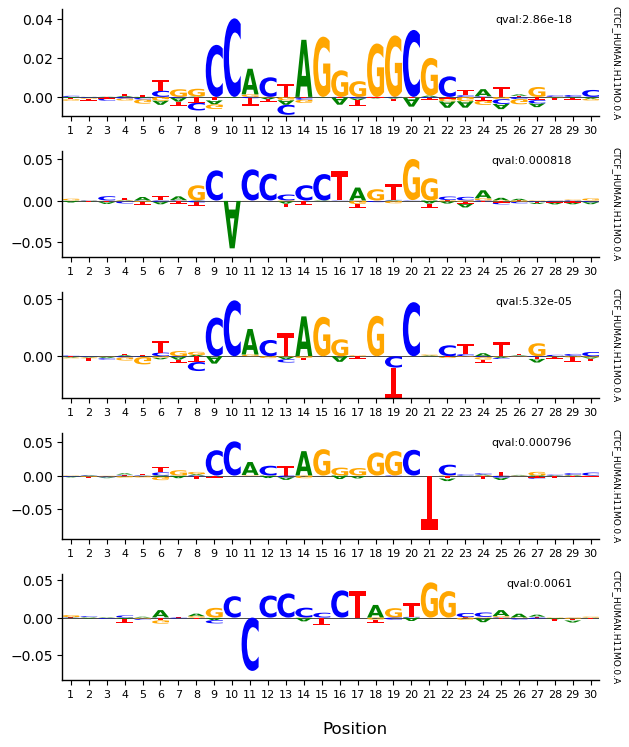

In [18]:
'''
Specify the motifs you want to plot (by Tomtom match name), or set to None to plot all
motifs_to_plot = ["motif_name_1", "motif_name_2", "motif_name_3"]
>> Use top match (match 0)

# Use second best match (match 1): (OPTIONAL)
def get_second_tomtom_match(tomtom_file):
   return get_top_tomtom_match(tomtom_file, match_index = 1)
motifs_to_plot = [get_second_tomtom_match(os.path.join(tomtom_dir,f"pos_patterns.pattern_{i}.tomtom.tsv")) for i in range(len(h5.File(hdf5_file,'r')['pos_patterns']))]
motifs_to_plot = [m for m in motifs_to_plot if m is not None] # remove None entries
'''

SAVE           = True
hdf5_file      = f"{ROOT_MODISCO}/modisco_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_results.h5"  # Replace with your file name
tomtom_dir     = f"{OUTPUT_DIR}/tomtom"
motifs_to_plot = None
pattern_type   = 'pos_patterns'

with h5.File(hdf5_file, 'r') as hf:

   print("Gathering data from HDF5 file: ", hdf5_file)

   # Extract and plot motifs
   try:
      p_motifs, p_seqlet_counts, p_qvalues, p_cwms = extract_motif_data(hf, 'pos_patterns', tomtom_dir, motifs_to_plot)
   except KeyError:
      p_motifs, p_seqlet_counts, p_qvalues, p_cwms = [], [], [], []

   try:  
      n_motifs, n_seqlet_counts, n_qvalues, n_cwms = extract_motif_data(hf, 'neg_patterns', tomtom_dir, motifs_to_plot)
   except KeyError:
      n_motifs, n_seqlet_counts, n_qvalues, n_cwms = [], [], [], []

   motifs         = p_motifs + n_motifs
   seqlet_counts  = p_seqlet_counts + n_seqlet_counts
   qvalues        = p_qvalues + n_qvalues
   cwms           = p_cwms + n_cwms

   # Plot found denovo motifs
   plot_motif_cwms(motifs, cwms, qvalues, OUTPUT_DIR, 5)

* stacked barchart of seqlet proportions

Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/../plots/Figure4/modisco/crested/modisco_train-BM-mm10_test-hg38_tf-CTCF_results.h5
Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/../plots/Figure4/modisco/crested/modisco_train-GRL-mm10_test-hg38_tf-CTCF_results.h5
Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/../plots/Figure4/modisco/crested/modisco_train-MORALE-mm10_test-hg38_tf-CTCF_results.h5
Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure

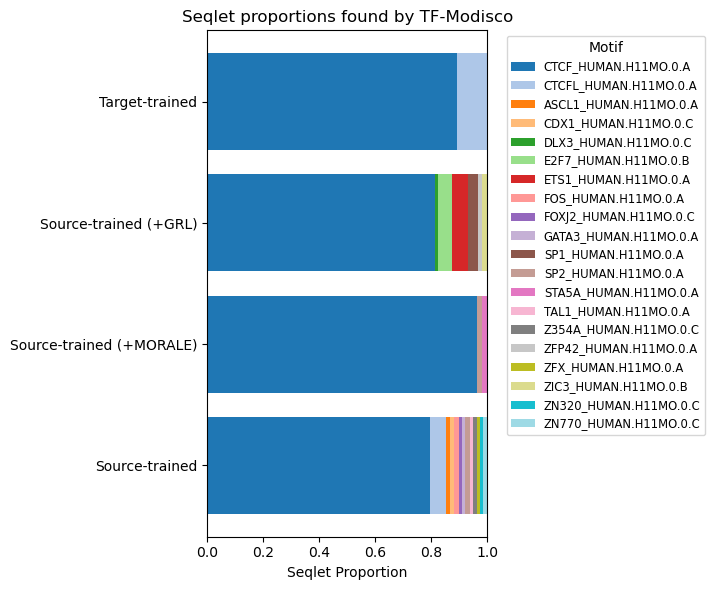

In [24]:
SAVE           = True

# Plot-acceptable names for model types
MODEL_NAMES = {
    f"BM-{SPECIES1}": "Source-trained",
    f"BM-{SPECIES2}": "Target-trained",
    f"GRL-mm10": "Source-trained\n(+GRL)",
    f"MORALE-mm10": "Source-trained\n(+MORALE)"
}

motifs         = {}
seqlet_counts  = {}
qvalues        = {}
cwms           = {}
for model_name in ["BM-mm10", "GRL-mm10", "MORALE-mm10", "BM-hg38"]:

   hdf5_file      = f"{ROOT_MODISCO}/modisco_train-{model_name}_test-{SPECIES2}_tf-{TF}_results.h5"  # Replace with your file name
   tomtom_dir     = f"{ROOT_MODISCO}/report_train-{model_name}_test-{SPECIES2}_tf-{TF}/tomtom"
   motifs_to_plot = None
   with h5.File(hdf5_file, 'r') as hf:

      print("Gathering data from HDF5 file: ", hdf5_file)

      # Extract and plot motifs
      try:
         p_motifs, p_seqlet_counts, p_qvalues, p_cwms = extract_motif_data(hf, 'pos_patterns', tomtom_dir, motifs_to_plot)
      except KeyError:
         p_motifs, p_seqlet_counts, p_qvalues, p_cwms = [], [], [], []

      try:  
         n_motifs, n_seqlet_counts, n_qvalues, n_cwms = extract_motif_data(hf, 'neg_patterns', tomtom_dir, motifs_to_plot)
      except KeyError:
         n_motifs, n_seqlet_counts, n_qvalues, n_cwms = [], [], [], []

      motifs[model_name]         = p_motifs + n_motifs
      seqlet_counts[model_name]  = p_seqlet_counts + n_seqlet_counts
      qvalues[model_name]        = p_qvalues + n_qvalues
      cwms[model_name]           = p_cwms + n_cwms

plot_stacked_bar(motifs, seqlet_counts, ROOT_MODISCO)

---